In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import linregress
import seaborn as sns
import pymc3 as pm
import arviz as az
import plot_helpers
import data_helpers
from data_helpers import gate_dataframe, canonical_data_frame


# Loading the Negative Controls data

In [3]:
df = pd.read_csv('negative_controls.csv')

In [4]:
df.shape[0]

1880086

In [5]:
df['strain_name'].unique()

array(['WT-Live-Control'], dtype=object)

In [6]:
if 'level_0' in df.columns:
    df.drop(columns='level_0', inplace=True)

In [7]:
df['inc_time_1_hrs'].unique(), df['inc_time_2_hrs'].unique()

(array([18, 16]), array([18, 15,  8, 16, 10, 12]))

In [8]:
df.set_index(['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event'], drop=True, inplace=True)

In [9]:
df['FSC_A'].max(), df['SSC_A'].max()

(1048575.0, 1048575.0)

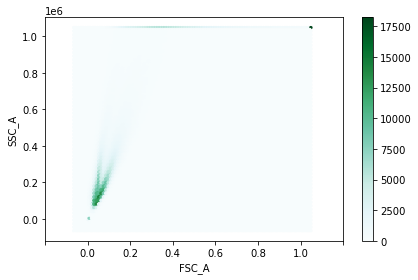

In [10]:
figure, ax = plt.subplots(1, 1)
df.plot.hexbin(x='FSC_A', y='SSC_A', ax=ax)
plt.gca().set_xlabel('FSC_A')
oticks, olabels = plt.xticks()
ticks, labels = plt.xticks(ticks=oticks, labels=['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', ''])
labels = plt.gca().set_xticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', ''])
plt.tight_layout()
plt.gcf().savefig('saturation_heatmap.pdf', format='pdf')


# Gate the Negative Control Data

True

In [65]:
odf = df.copy()
odf.add
df = gate_dataframe(df)

KeyError: 'Level lab_id not found'

In [12]:
df.inc_time_1_hrs.unique()

array([18, 16])

In [13]:
df[df['inc_time_1_hrs'] == 16].lab_id.unique()

array(['r1c5va9wyf3mx_r1c63bjzu5ruy', 'r1c5vad8u7ve2_r1c66q7cru28u',
       'r1c5vac658fxn_r1c66qw595ydy'], dtype=object)

In [14]:
df[df['inc_time_1_hrs'] == 18].lab_id.unique()

array(['r1ceuhqmu6c7w_r1cf6snbv99p8', 'r1c84xwx57y95_r1c8ejz8jfg9z',
       'r1cft9hhnhjdb_r1cfwgjmz247y', 'r1cyeyjwbefaf2_r1cys7qtr6j42x',
       'r1c7cpvfzqprk_r1c7fbvba55db', 'r1cdcetsvxgc2_r1cdfa6jrtssc',
       'r1c8yyg9gxbme_r1c96wn43pq45', 'r1ce3pjymvm3u_r1ceb3rgpe8gm',
       'r1ce3pqt45vfe_r1ce7qf5e483u', 'r1ceuhvgf7b4y_r1cf2yr353x5j',
       'r1cwvvxz5d7wua_r1cx7ucsnkjfsb', 'r1c84y3r9yqxb_r1c8auwvzbgt3',
       'r1c8yydkumrkr_r1c96xsxw79c9', 'r1cgbw3xk7pau_r1cgpa54x8ff3',
       'r1cckyh56hjqj_r1ccpyjef2vca', 'r1cfkpp2p3kjz_r1cftpr8wxqc7',
       'r1c8xx7we38vw_r1c93cukfcxqp', 'r1cbut53kpf3n_r1cc3bn2s2aj8',
       'r1cdcesknarkf_r1cdfg4x5uuwp', 'r1d6r8mvznxxme_r1d8jxmssfag5w',
       'r1c7cprv7fe49_r1c7jmje3ebhc', 'r1cdfr4bjcnrg_r1cdnuqex83dm',
       'r1cbut3veu2z4_r1cc6efukqtxx', 'r1cfkpuz2kr6c_r1cfpvk5hjkzb',
       'r1cgbw8qkp6z4_r1cgjpjx5ve76', 'r1cgbw7hjvxgx_r1cgjxrexhd4j',
       'r1c7cpu9nj2bu_r1c7fg23qkzph', 'r1cyey8rzxq269_r1cysrdt3pvt5n',
       'r1ccqfbz332u8_r1cc

# Remove data with 16h recovery time

There are not many of these -- only three plates -- and they were done with an earlier version of the protocol.  They also seem to have other oddities.

In [15]:
df = df[df['inc_time_1_hrs'] == 18]

In [16]:
df.loc[:, 'log_FSC_A'] = np.log10(df.FSC_A)
df.loc[:, 'log_SSC_A'] = np.log10(df.SSC_A)

/home/rpg/anaconda3/envs/replication/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_5422/1808678610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'log_FSC_A'] = np.log10(df.FSC_A)
/home/rpg/anaconda3/envs/replication/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_5422/1808678610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

# Try to make models

## Unimodal

First get a linear regression line to give an informed prior.

In [17]:
df.log_FSC_A.values, df.log_SSC_A.values

(array([6.0205995 , 5.52932254, 5.81646204, ..., 5.69405474, 5.00519339,
        5.36762611]),
 array([6.0205995 , 6.0205995 , 6.0205995 , ..., 6.0205995 , 5.50192698,
        5.73322616]))

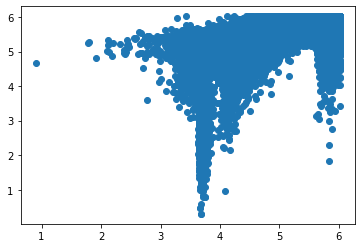

In [18]:
plt.scatter(df.log_FSC_A.values, df.log_SSC_A.values)

<AxesSubplot:xlabel='FSC_A', ylabel='SSC_A'>

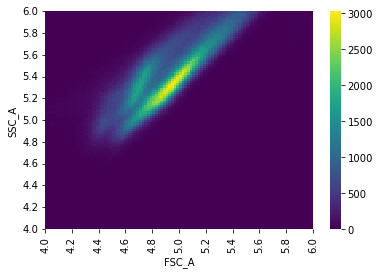

In [19]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df, logscale=True), logscale=True)

In [20]:
with pm.Model('Unimodal Model') as model:
    df = df.dropna(subset=['log_FSC_A', 'log_SSC_A'])
    assert df.log_FSC_A.shape[0] == df.log_SSC_A.shape[0]
    
    theta = pm.TruncatedNormal('theta', mu=1, sigma=0.5, lower=0)
    beta = pm.Normal('beta', mu=0, sd=1)
    theta2 = pm.InverseGamma('theta2', alpha=1, beta=1)
    x = pm.Data('x', df.log_FSC_A.values)
    y = pm.Normal('y', mu=theta * x + beta, sd=theta2, observed=df.log_SSC_A.values)
    

In [ ]:
id = az.from_netcdf('unimodal_model.ncd')

In [57]:
b_id = az.from_netcdf('bimodal_model.ncd')

array([<AxesSubplot:title={'center':'Unimodal Model_beta'}>,
       <AxesSubplot:title={'center':'Unimodal Model_theta'}>,
       <AxesSubplot:title={'center':'Unimodal Model_theta2'}>],
      dtype=object)

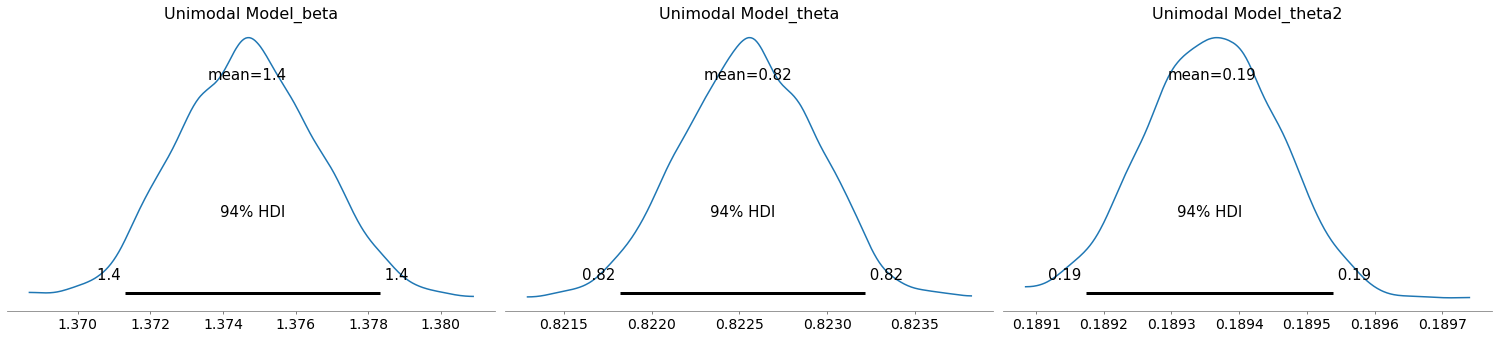

In [23]:
az.plot_posterior(id)

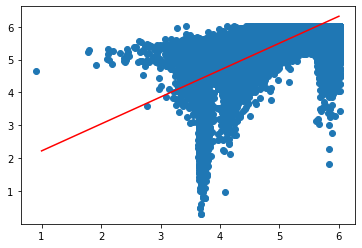

In [24]:
plt.scatter(df.log_FSC_A.values, df.log_SSC_A.values)
xs = np.linspace(1, 6, 100)
ys = 0.82 * xs + 1.4
ax = plt.gca()
ax.plot(xs, ys, color='red')


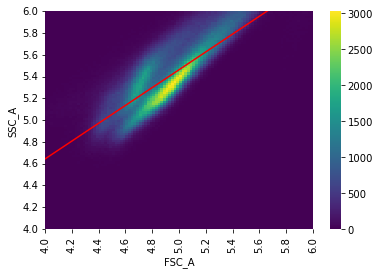

In [56]:
ax = plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df, logscale=True), logscale=True)
xs = np.linspace(4, 6, 100)
ys = 0.82 * xs + 1.4
points = np.vectorize(lambda x, y: plot_helpers.translate(x, y, logscale=True))
xs, ys = points(xs, ys)
ax.plot(xs, ys, color='red')



How the unimodal model was fitted:

``` python
with model:
    res = pm.sample(tune=2000, draws=1000, return_inferencedata=True)
    
res.to_netcdf("unimodal_model.ncd")
```

In [58]:
with pm.Model('Bimodal Model') as model2:
    df = df.dropna(subset=['log_FSC_A', 'log_SSC_A'])
    assert df.log_FSC_A.shape[0] == df.log_SSC_A.shape[0]
    x = pm.Data('x', np.array([df.log_FSC_A, df.log_FSC_A]).T)
    
    thetas = pm.TruncatedNormal('theta', 
                                mu=1, sigma=0.5, 
                                lower=0, shape=(2,), 
                                transform=pm.transforms.ordered,
                               testval=np.array([1, 1.5]))
    betas = pm.Normal('beta', mu=0, sd=1, shape=2)
    theta2 = pm.InverseGamma('theta2', alpha=1, beta=1, shape=2)
    wgts = pm.Dirichlet('w', a=np.array([2, 6]))
    ys = pm.Normal.dist(mu=thetas * x + betas, sd=theta2)
    mix = pm.Mixture('obs', w=wgts, comp_dists=ys, observed=df.log_SSC_A.values)
    

Fitting the bimodal model:
``` python
with model2:
    res2 = pm.sample(tune=1000, draws=500, return_inferencedata=True,
                    init="adapt_diag") # try to fix twitchy sampling
    
res2.to_netcdf("bimodal_model.ncd")
```

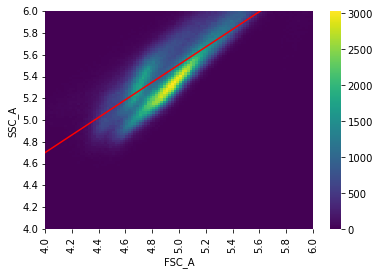

In [74]:
ax = plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df, logscale=True), logscale=True)

xs = np.linspace(4, 6, 100)
ys = 0.81 * xs + 1.5
points = np.vectorize(lambda x, y: plot_helpers.translate(x, y, logscale=True))
xs, ys = points(xs, ys)
ax.plot(xs, ys, color='red')
first_ys = ys

xs = np.linspace(4, 6, 100)
ys = 0.18 * xs + 1
xs, ys = points(xs, ys)
ax.plot(xs, ys, color='orange')

In [89]:
from imp import reload
reload(plot_helpers)

<module 'plot_helpers' from '/home/rpg/projects/xplan/replication-paper-data-analysis/plot_helpers.py'>

In [97]:
-1.435/0.141

-10.177304964539008

(25.0, 310.0)


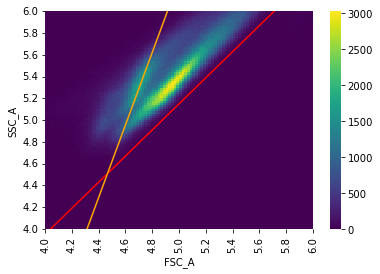

In [96]:
ax = plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df, logscale=True), logscale=True)

xs = np.linspace(4, 6, 100)
m1 = 1.2 ; b1 = -0.65
ys = m1 * xs + b1
points = np.vectorize(lambda x, y: plot_helpers.translate(x, y, logscale=True))
xs, ys = points(xs, ys)
ax.plot(xs, ys, color='red')
first_ys = ys

print(plot_helpers.translate(4.5, 0, logscale=True))

#ax.axline(plot_helpers.translate(4.25, 4.0, logscale=True), plot_helpers.translate(4.85, 6, logscale=True), color='orange')
xs = np.linspace(4, 6, 100)
m = 3 + 1/3 ; b = -1.435/0.141
ys = m * xs + b
xs, ys = points(xs, ys)
ax.plot(xs, ys, color='orange')

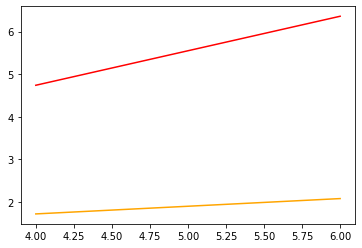

In [73]:
fig, ax = plt.subplots(1, 1)

xs = np.linspace(4, 6, 100)
ys = 0.81 * xs + 1.5
ax.plot(xs, ys, color='red')

xs = np.linspace(4, 6, 100)
ys = 0.18 * xs + 1
ax.plot(xs, ys, color='orange')

# Need to look at the mixture model labelings

See [this question on PyMC3 discourse](https://discourse.pymc.io/t/get-the-likelihood-generative-distribution-of-observation-from-a-mixture-model/2196/3)